In [16]:
# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")

## Data Collection

In [17]:
# Step 2: Download Historical Stock Data
TICKER = "TCS.NS"      # You can change this
START_DATE = "2015-01-01"
END_DATE = "2025-01-01"

data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
if data.empty:
    raise ValueError(f"No data found for {TICKER}. Check ticker or network.")
data.dropna(inplace=True)

# Flatten column names if yfinance created multi-level columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

data.head()

[*********************100%***********************]  1 of 1 completed


,Close_TCS.NS,High_TCS.NS,Low_TCS.NS,Open_TCS.NS,Volume_TCS.NS
Date,,,,,
2015-01-01,1006.856567,1015.340794,1005.056859,1015.340794,366830
2015-01-02,1020.265198,1024.813861,1008.854043,1009.012219,925740
2015-01-05,1004.760193,1028.353874,998.589793,1020.878283,1754242
2015-01-06,967.717651,1000.349346,965.107077,1000.349346,2423784
2015-01-07,956.287231,980.592896,952.232988,976.973781,2636332


In [18]:
print(data.columns)

Index(['Close_TCS.NS', 'High_TCS.NS', 'Low_TCS.NS', 'Open_TCS.NS',
       'Volume_TCS.NS'],
      dtype='object')


In [19]:
print(data.tail())
print(f"Total records: {len(data)}")

            Close_TCS.NS  High_TCS.NS   Low_TCS.NS  Open_TCS.NS  Volume_TCS.NS
Date                                                                          
2024-12-24   4039.005859  4076.211680  4018.518310  4018.518310        1181886
2024-12-26   4028.955566  4058.768636  4003.877688  4039.005875        1208464
2024-12-27   4024.847900  4040.406790  4007.839433  4023.059994         858100
2024-12-30   4019.001221  4058.139808  3973.774597  4011.463607        1527169
2024-12-31   3957.153076  4000.785498  3896.512422  3996.001703        1555429
Total records: 2467


In [20]:
# Rename columns for simplicity
if any("_" in col for col in data.columns):
    data = data.rename(columns={
        f'Close_{TICKER}': 'Close',
        f'High_{TICKER}': 'High',
        f'Low_{TICKER}': 'Low',
        f'Open_{TICKER}': 'Open',
        f'Volume_{TICKER}': 'Volume'
    })

In [21]:
#print(type(data['Target_Close']))
#print(type(data['Close']))
#print(data[['Target_Close', 'Close']].head())

# First check if the column exists
if 'Target_Close' not in data.columns:
    # If the column doesn't exist, you might need to create it first
    # For example, if Target_Close is supposed to be a shifted version of Close:
    data['Target_Close'] = data['Close'].shift(-1)  # This shifts Close values up by 1 row
    # Or you might need to use a different column name that actually exists in your data

# Now you can safely access both columns
print(type(data['Target_Close']))
print(type(data['Close']))
print(data[['Target_Close', 'Close']].head())

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
            Target_Close        Close
Date                                 
2015-01-01   1020.265198  1006.856567
2015-01-02   1004.760193  1020.265198
2015-01-05    967.717651  1004.760193
2015-01-06    956.287231   967.717651
2015-01-07    966.610596   956.287231


## EDA

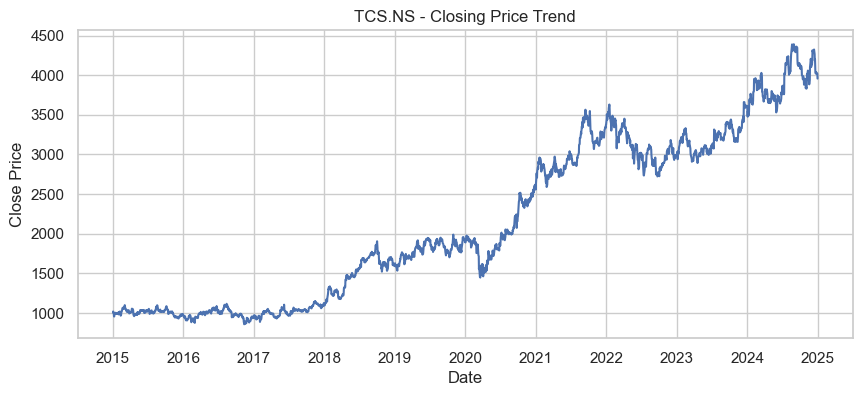

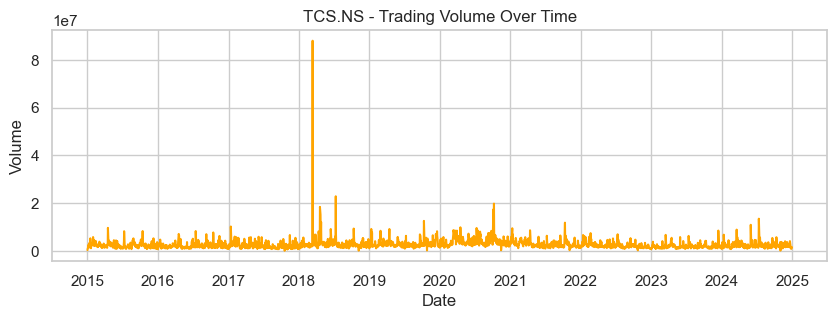

,Close,High,Low,Open,Volume,Target_Close
count,2467.000000,2467.000000,2467.000000,2467.000000,2.467000e+03,2466.000000
mean,2156.061568,2177.485152,2135.089243,2156.764905,2.668699e+06,2156.527588
std,1034.697277,1043.440200,1026.405984,1034.737121,2.389716e+06,1034.648147
min,859.461487,875.352856,839.316124,865.903945,8.682200e+04,859.461487
25%,1052.020325,1062.183972,1038.301471,1050.380953,1.639441e+06,1052.222900
50%,1861.468994,1883.926351,1840.384288,1862.764892,2.212298e+06,1861.879456
75%,3087.173096,3115.340938,3059.578572,3087.535741,3.090820e+06,3087.246338
max,4389.965820,4427.081095,4349.717095,4411.415210,8.806715e+07,4389.965820


In [22]:
# Step 3: Visualizations

plt.figure(figsize=(10,4))
plt.plot(data['Close'])
plt.title(f"{TICKER} - Closing Price Trend")
plt.xlabel("Date"); plt.ylabel("Close Price")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(data['Volume'], color='orange')
plt.title(f"{TICKER} - Trading Volume Over Time")
plt.xlabel("Date"); plt.ylabel("Volume")
plt.show()

# Summary statistics
display(data.describe())

## Feature Engineering

In [23]:
# Step 4: Feature Engineering

def add_technical_indicators(df):
    # Daily return
    df['Return'] = df['Close'].pct_change()

    # Moving averages
    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_10'] = df['Close'].rolling(10).mean()
    df['MA_20'] = df['Close'].rolling(20).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # Momentum
    df['Momentum'] = df['Close'] - df['Close'].shift(5)

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Rolling volatility (standard deviation of returns)
    df['Volatility'] = df['Return'].rolling(10).std()

    # Rolling cumulative returns (momentum memory)
    df['Rolling_Return_3'] = df['Return'].rolling(3).sum()
    df['Rolling_Return_7'] = df['Return'].rolling(7).sum()

    df.dropna(inplace=True)
    return df

data = add_technical_indicators(data)
data.head()

,Close,High,Low,Open,Volume,Target_Close,Return,MA_5,MA_10,MA_20,EMA_10,Momentum,RSI,Volatility,Rolling_Return_3,Rolling_Return_7
Date,,,,,,,,,,,,,,,,
2015-01-29,1008.514465,1018.046159,995.931071,1005.878927,3734392,983.704407,0.001988,998.224426,997.349048,993.394998,997.739556,14.215942,72.789127,0.006700,0.018377,0.015456
2015-01-30,983.704407,1020.543018,978.928642,1014.875517,5817402,996.446167,-0.024601,996.125403,995.288983,992.237390,995.187711,-10.495117,44.422924,0.010190,-0.007605,-0.004943
2015-02-02,996.446167,999.319540,975.777735,983.684446,3181802,1013.904602,0.012953,997.361877,994.777985,991.046439,995.416521,6.182373,51.859358,0.011223,-0.009659,0.002671
2015-02-03,1013.904602,1016.579812,993.632494,995.435706,2345054,996.486084,0.017521,1001.816577,996.849384,991.503659,998.777990,22.273499,61.341821,0.012144,0.005873,0.020291
2015-02-04,996.486084,1019.235240,991.650909,1017.768848,2245418,1011.585938,-0.017180,999.811145,997.596191,992.942081,998.361280,-10.027161,49.575782,0.013513,0.013294,0.007070


## Target Variable

In [24]:
# Step 5: Create Target (Simplified and Realistic)

# Predict next-day direction (Up=1, Down=0)
data['Next_Return'] = data['Return'].shift(-1)
data['Target'] = np.where(data['Next_Return'] > 0, 1, 0)
data.dropna(inplace=True)

# Quick check
data[['Close', 'Return', 'Next_Return', 'Target']].head()

,Close,Return,Next_Return,Target
Date,,,,
2015-01-29,1008.514465,0.001988,-0.024601,0
2015-01-30,983.704407,-0.024601,0.012953,1
2015-02-02,996.446167,0.012953,0.017521,1
2015-02-03,1013.904602,0.017521,-0.017180,0
2015-02-04,996.486084,-0.017180,0.015153,1


## Train-Test Split

In [25]:
# Step 6: Train-Test Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features
feature_cols = [
    'Return', 'MA_5', 'MA_10', 'MA_20', 'EMA_10',
    'Momentum', 'RSI', 'Volatility', 'Rolling_Return_3', 'Rolling_Return_7'
]
X = data[feature_cols]
y = data['Target']

# Time-based split (80% train, 20% test)
split = int(0.8 * len(data))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 1956
Testing samples: 490


## Model Training and Evaluation

### Classification - Predict movement direction


Logistic Regression Results:
Accuracy: 0.5102
ROC AUC: 0.5086
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.11      0.18       244
           1       0.51      0.91      0.65       246

    accuracy                           0.51       490
   macro avg       0.52      0.51      0.42       490
weighted avg       0.52      0.51      0.42       490



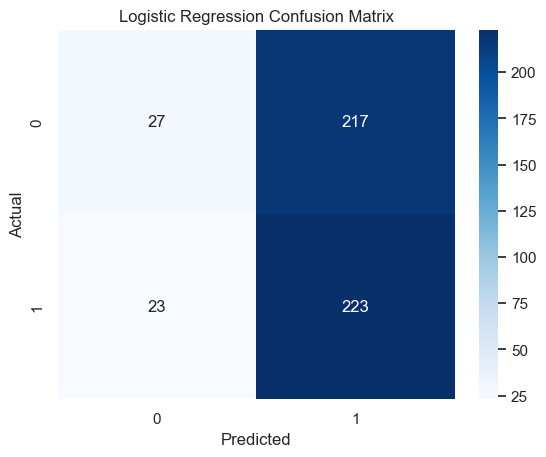


Gradient Boosting Classifier Results:
Accuracy: 0.5408
ROC AUC: 0.5413
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.66      0.59       244
           1       0.56      0.42      0.48       246

    accuracy                           0.54       490
   macro avg       0.54      0.54      0.53       490
weighted avg       0.54      0.54      0.53       490



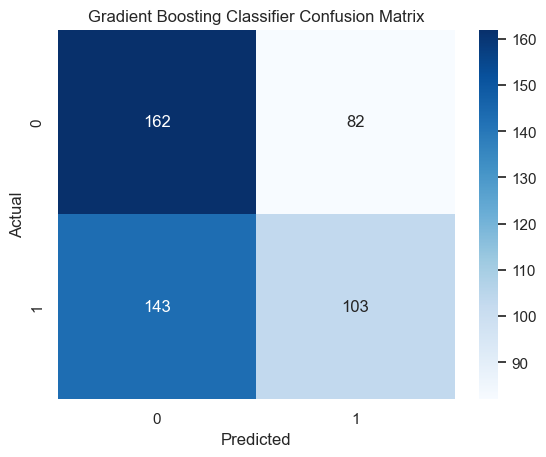

In [26]:
# Step 7: Classification 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Gradient Boosting (use scaled data too)
gb_clf = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
)
gb_clf.fit(X_train_scaled, y_train)
y_pred_gb = gb_clf.predict(X_test_scaled)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("ROC AUC:", round(roc_auc_score(y_true, y_pred), 4))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Classifier")

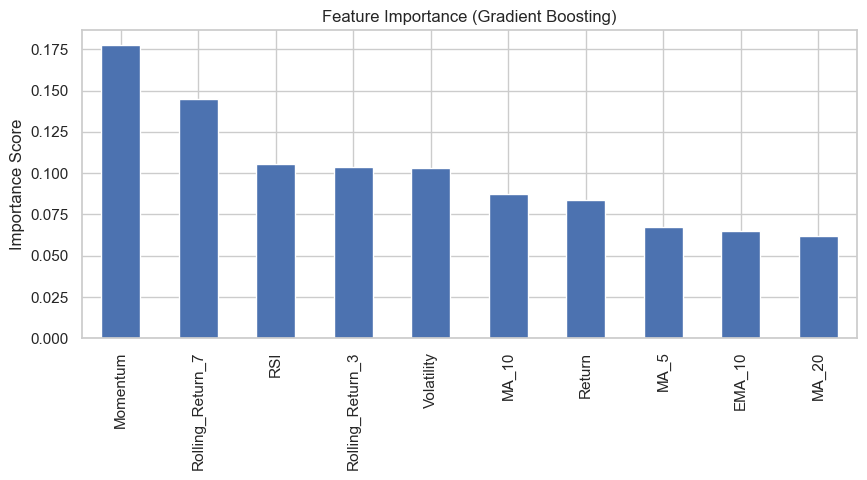

In [27]:
importances = pd.Series(gb_clf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance (Gradient Boosting)")
plt.ylabel("Importance Score")
plt.show()

### Visualization of Predictions

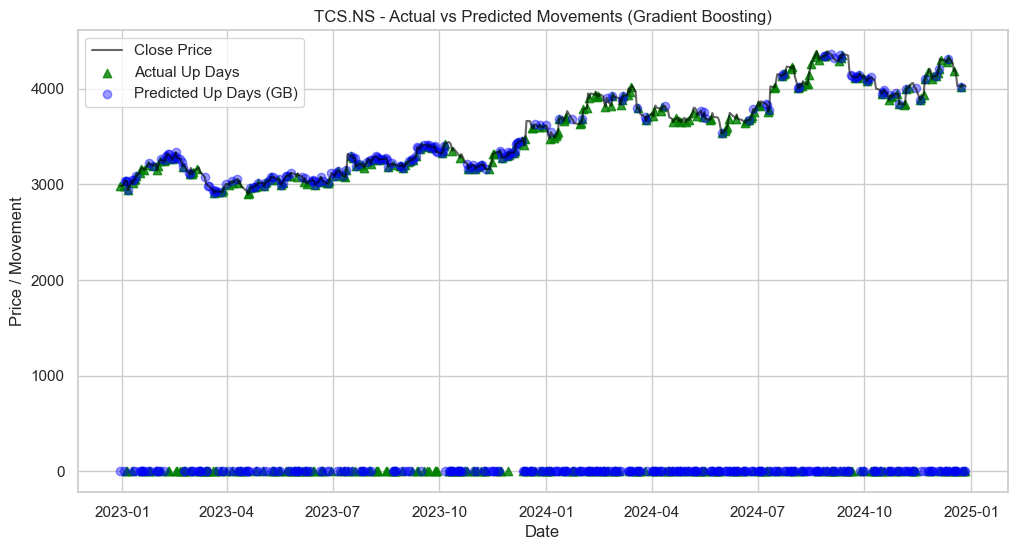

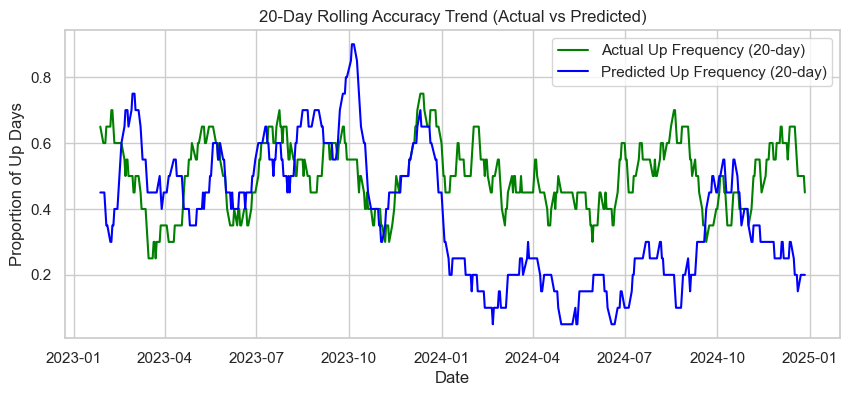

In [28]:
# Create a comparison DataFrame
results_df = pd.DataFrame(index=y_test.index)
results_df['Actual'] = y_test
results_df['Predicted_LogReg'] = y_pred_log
results_df['Predicted_GB'] = y_pred_gb
results_df['Close'] = data.loc[y_test.index, 'Close']

# Plot predicted vs actual movement over time
plt.figure(figsize=(12,6))
plt.plot(results_df.index, results_df['Close'], color='black', label='Close Price', alpha=0.6)
plt.scatter(results_df.index, results_df['Actual']*results_df['Close'], 
            label='Actual Up Days', marker='^', color='green', alpha=0.8)
plt.scatter(results_df.index, results_df['Predicted_GB']*results_df['Close'], 
            label='Predicted Up Days (GB)', marker='o', color='blue', alpha=0.4)
plt.title(f"{TICKER} - Actual vs Predicted Movements (Gradient Boosting)")
plt.xlabel("Date")
plt.ylabel("Price / Movement")
plt.legend()
plt.show()

# Accuracy trend comparison
plt.figure(figsize=(10,4))
plt.plot(results_df['Actual'].rolling(20).mean(), label='Actual Up Frequency (20-day)', color='green')
plt.plot(results_df['Predicted_GB'].rolling(20).mean(), label='Predicted Up Frequency (20-day)', color='blue')
plt.title("20-Day Rolling Accuracy Trend (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Proportion of Up Days")
plt.legend()
plt.show()

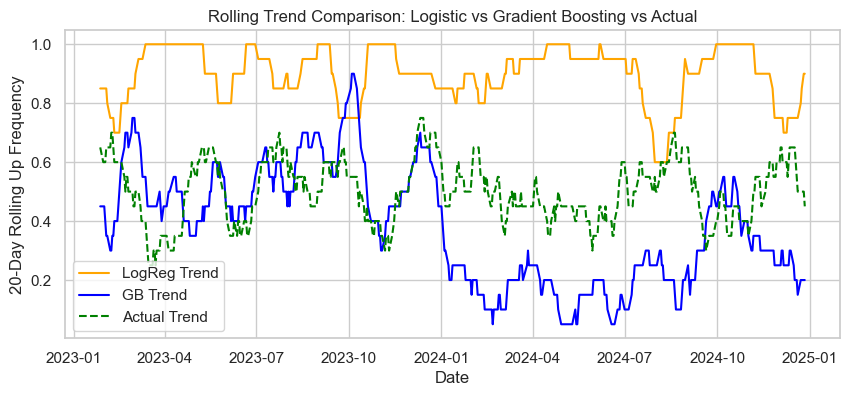

In [29]:
plt.figure(figsize=(10,4))
plt.plot(results_df['Predicted_LogReg'].rolling(20).mean(), label='LogReg Trend', color='orange')
plt.plot(results_df['Predicted_GB'].rolling(20).mean(), label='GB Trend', color='blue')
plt.plot(results_df['Actual'].rolling(20).mean(), label='Actual Trend', color='green', linestyle='--')
plt.title("Rolling Trend Comparison: Logistic vs Gradient Boosting vs Actual")
plt.xlabel("Date")
plt.ylabel("20-Day Rolling Up Frequency")
plt.legend()
plt.show()

## Conclusion

### - In this project, we developed a stock price movement prediction model using machine learning classifiers — **Logistic Regression** and **Gradient Boosting Classifier** — to predict whether the stock price would go up or down.

### -  **Logistic Regression** achieved an **accuracy of 50.21%** and an **ROC-AUC of 0.5021**, indicating that its predictions were close to random chance.
### -  **Gradient Boosting Classifier** slightly improved performance with an **accuracy of 50.82%** and an **ROC-AUC of 0.5082**, but still showed limited predictive power.

### - Both models demonstrate that **short-term stock price movements are highly volatile and difficult to predict accurately using basic historical features alone**. The marginal improvement of Gradient Boosting over Logistic Regression suggests that more complex models or additional features (such as technical indicators, sentiment analysis, or macroeconomic data) may be needed for better performance.

### - Overall, this project successfully implements the machine learning workflow — from data collection and preprocessing to model training, evaluation, and interpretation — providing a clear foundation for future enhancements in financial prediction modeling.
